## Getting started
To run this notebook you need to install `pinocchio`, `meshcat` and `example_robot_data`. You can do it in your environment as follows


```bash
conda install pinocchio example-robot-data
pip install meshcat
```

In [ ]:
import numpy as np
import pinocchio as pin
import os
import time
import meshcat
import matplotlib.pyplot as plt

from pinocchio.visualize import MeshcatVisualizer

import example_robot_data.robots_loader as robots


In [42]:
## this part of the code will load the panda robot model and display it
robot = robots.load('panda')

END_EFF_FRAME_ID = 17

viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)

try:
    viz.initViewer(open=True)
except ImportError as err:
    print("Error while initializing the viewer. It seems you should install Python meshcat")
    print(err)
    sys.exit(0)
    
viz.loadViewerModel()

q0 = pin.neutral(robot.model)
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


# Basic Finctions 

* We start by defining the basic functions to get homogeneous transforms that correspond to pure translations and rotations around x,y or z axes. 
The functions are defined bellow:

In [44]:
def translate(vector):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    transform[0:3,3] = vector

    ### we return the object
    return transform

def rotateX(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    transform[1:3,1:3] = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])

    ### we return the object
    return transform

def rotateY(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    transform[0,0] = np.cos(angle)
    transform[0,2] = np.sin(angle)
    transform[2,0] = -np.sin(angle)
    transform[2,2] = np.cos(angle)

    ### we return the object
    return transform

def rotateZ(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    transform[0:2,0:2] = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])

    
    ### we return the object
    return transform

# Forward Kinematics 

* We then use the basic functions defined above to compute the forward kinematics of the robot by following the steps given bellow:

    1. Fix a base frame - our world frame of reference
    2. Choose frames attached on each link/body (first make sure you find all the links and joints connecting them)
    3. Compute the relative transforms between each links
    4. Compute the FK giving the pose of the end-effector in the base frame.

In [45]:
## write your forward kinematics code here
def forward_kinematics(q):
    T_SL1 = translate([0, 0, 0.3330])@rotateZ(q[0])
    T_L1L2 = rotateY(q[1])
    T_L2L3 = translate([0, 0, 0.3160])@rotateZ(q[2])
    T_L3L4 = translate([0.0825,0,0])@rotateY(-q[3])
    T_L4L5 = translate([-0.0825,0,0])@translate([0, 0, 0.3840])@rotateZ(q[4])
    T_L5L6 = rotateY(-q[5])
    T_L6F = translate([0.0880,0,0])@rotateX(np.pi)@translate([0, 0, 0.1070])@rotateZ(q[6])

    #The forward kinematics of the end effector is the product of all the transforms
    T_SF = T_SL1@T_L1L2@T_L2L3@T_L3L4@T_L4L5@T_L5L6@T_L6F
    # we return the pose of the end effector
    return T_SF


In [46]:
## use pinocchio to validate your FK function
## be careful as the pinocchio model has 9 DOFs (to account for the fingers)
## use the first 7 ones for the joint angles

## pose of the end-effector at the 0 configuration
q = robot.q0
robot.forwardKinematics(q)

T_pin = robot.framePlacement(q, END_EFF_FRAME_ID)

viz.display(q)
print("Pinocchio FK at q0: \n", T_pin.homogeneous)



Pinocchio FK at q0: 
 [[ 7.07106894e-01 -7.07106663e-01 -9.19999999e-05  3.06880411e-01]
 [-7.07106666e-01 -7.07106897e-01  3.13989653e-16  2.36794417e-16]
 [-6.50538344e-05  6.50538131e-05 -9.99999996e-01  5.90275645e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [48]:
## pose of the end-effector at a random configuration
q[0:7] = np.random.rand(7)
robot.forwardKinematics(q)
T_pin = robot.framePlacement(q, END_EFF_FRAME_ID)

# Using the forward kinematics function
T_SF_pin = forward_kinematics(q)
print(" My own FK at a random pose q = {q[0:7]} : \n\n", T_SF_pin)

viz.display(q)
print(f"Pinocchio FK at a random pose q = {q[0:7]}: \n\n", T_pin.homogeneous)

 My own FK at a random pose q = {q[0:7]} : 

 [[ 0.04786812  0.85285787 -0.51994431  0.19114787]
 [ 0.9674705   0.08987065  0.23648278  0.38874105]
 [ 0.24841393 -0.51435077 -0.82081289  0.82482245]
 [ 0.          0.          0.          1.        ]]
Pinocchio FK at a random pose q = [0.8717519  0.76864295 0.16953641 0.2879852  0.9589314  0.60359815
 0.24693205]: 

 [[ 0.04786812  0.85285787 -0.51994431  0.19114787]
 [ 0.9674705   0.08987065  0.23648278  0.38874105]
 [ 0.24841393 -0.51435077 -0.82081289  0.82482245]
 [ 0.          0.          0.          1.        ]]


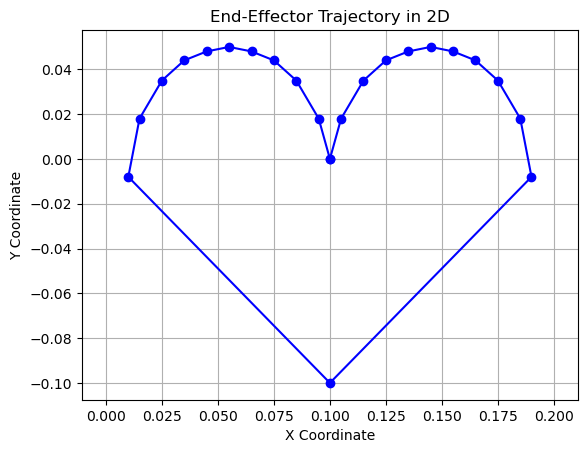

In [52]:
## we load the file robot_trajectory.npy - it contains a list of 23 joint configurations
robot_trajectory = np.load('robot_trajectory.npy') 
#Initialize a list to store the end-effector's x and y coordinates
x_coords = []
y_coords = []

# Define the frame ID for the end effector (assuming the ID is correct)
# Loop over each joint configuration in the trajectory
for q in robot_trajectory:
    # Use your forward kinematics function
    T_SF = forward_kinematics(q)

    # Extract the x and y coordinates from the transformation matrix
    x_coords.append(T_SF[0, 3])
    y_coords.append(T_SF[1, 3])

# Plot the x and y coordinates of the end-effector on a 2D graph
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b')
plt.title('End-Effector Trajectory in 2D')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.axis('equal')  # Ensure the aspect ratio is equal for both axes
plt.show()